# Chain Using LangGraph  

In this section, we will learn how to build a simple chain using **LangGraph**.  
A **chain** here means connecting different steps (like handling messages, using a chat model, calling tools, and updating states) in a structured way.  

We will focus on 4 important concepts:  
1. Using chat messages as our graph state  
2. Using chat models in graph nodes  
3. Binding tools to our LLM in chat models  
4. Executing tool calls inside graph nodes  



In [74]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")



---
## 1. Using Chat Messages as Graph State  

In LangGraph, the **state** is like memory that flows between different nodes of the graph.  
Instead of passing just plain text, we pass **messages**.  

### Message Types in LangChain  
LangChain provides different types of messages to represent roles in a conversation:  

- **HumanMessage** → represents input from a human/user  
- **AIMessage** → represents output generated by the AI model  
- **SystemMessage** → provides instructions or context to guide the AI model’s behavior  
- **ToolMessage** → represents responses from tools (like a calculator or an API)  

### Components of a Message  
Each message contains three key components:  
- **content** → actual text of the message  
- **name** → name of the author or source of the message  
- **response_metadata** → optional dictionary to store extra metadata (e.g., information provided by the model provider)  

This structure makes it easy to maintain conversation history and keep track of who said what.  


In [75]:
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint

messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
messages.append(HumanMessage(content=f"I want to learn coding",name="Nidhi"))
messages.append(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn python programming language",name="Nidhi"))

for message in messages:
    message.pretty_print()



================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help
================================ Human Message =================================
Name: Nidhi

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn
================================ Human Message =================================
Name: Nidhi

I want to learn python programming language


---

## 2. Chat Models  

Once we have a sequence of messages, we can feed them into **chat models** like OpenAI, Anthropic, or Groq models.  

- Chat models are different from plain text completion models because they are designed for **multi-turn conversations**.  
- They understand **who is speaking** (human vs AI) and can produce responses that align with conversational flow.  

In LangGraph, each **graph node** can contain a chat model, which processes incoming messages and outputs new ones.  


In [76]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.1-8b-instant")
result = llm.invoke(messages)

In [77]:
result.response_metadata

{'token_usage': {'completion_tokens': 539,
  'prompt_tokens': 76,
  'total_tokens': 615,
  'completion_time': 0.756578801,
  'prompt_time': 0.004062799,
  'queue_time': 0.045400651,
  'total_time': 0.7606416},
 'model_name': 'llama-3.1-8b-instant',
 'system_fingerprint': 'fp_e32974efee',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None}

---

## 3. Tools  

Tools are external functions or systems that can be connected to the LLM.  
These could be:  
- APIs (weather, finance, stock market, etc.)  
- Local functions (like a calculator)  
- Databases or third-party applications  

### Example  
- **User:** “What is 2 plus 2?”  
- **LLM:** Instead of giving the answer directly, it calls the **calculator tool**.  
- **Tool:** returns `4`.  
- **LLM:** responds with “The answer is 4.”  

👉 This makes the AI **more powerful and practical**, since it can interact with the outside world instead of only generating text.  


In [81]:
def add(a : int, b : int)->int:
    """Add a anb b
    Args:
        a (int): first int
        b (int): second int
    Returns:
        int
    """
    return a+b


In [82]:
llm 

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002890A7CEBF0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002890A7CCE80>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

## 4. Binding Tools with LLM  

Just having tools is not enough — we must **bind** them to the LLM.  
Binding means *connecting* the tools to the model so the model knows these tools exist and can call them when needed.  

When tools are bound, the LLM can:  
- Detect if a user’s query requires a tool  
- Call the correct tool automatically  
- Use the tool’s response to answer the user  

✅ This turns the chatbot into a true **agent** that can both **reason and act**.  


In [83]:
### Binding tool with llm

llm_with_tools = llm.bind_tools([add])
tool_call =  llm_with_tools.invoke([HumanMessage(content="what is 2 plus 2", name="Nidhi")])


In [84]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'dt45r0r6r',
  'type': 'tool_call'}]

---

## 5. Using Messages as State  

Since conversations are dynamic, we need to store all previous messages as part of the **state**.  
If we just overwrite the messages with each new response, we would lose the conversation history.  

To solve this, we use **reducers**.  

In [85]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class State(TypedDict):
    message:list[AnyMessage]


---

## 6. Reducers  

A **reducer** defines how new values update the state.  

- **By default** → the new value overrides the old one  
- **With reducers** → we can customize the update process  

For messages, we don’t want to override.  
We want to **append** each new message to the existing list.  

LangGraph provides a built-in reducer called **`add_messages`**.  
- This ensures new messages are always added to the list of old messages  
- The **entire conversation history** is preserved  


In [86]:

from langgraph.graph.message import add_messages
from typing import Annotated
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

### Reducers with add_messages

In [87]:

initial_messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Nidhi"))
initial_messages

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Nidhi')]

In [88]:
ai_message=AIMessage(content=f"Which programming language you want to learn",name="LLMModel")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [89]:
### Reducers add_messages is to append instead of override
add_messages(initial_messages,ai_message)


[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='75987b14-3ccd-4bbb-80d4-8fe44442928e'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Nidhi', id='8f61d9c0-b4d5-46cd-8b2d-ca9c14ed9b54'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='a5fb3e69-d653-4783-a16f-4710be30aaba')]

## 7. Chatbot Node Functionality  

A **node** in LangGraph is a unit of work.  

Examples of nodes:  
- One node can represent the **LLM generating a response**  
- Another node can represent a **tool being called**  
- Another node can represent **state update**  

By combining nodes, we can build **complex conversational agents**.  

Nodes are connected using **edges**, which define how the flow moves from one node to another.  

### Example Flow  

START → LLM Node → Tool Node → END

This means:  
1. Start conversation  
2. LLM processes the query  
3. If needed, LLM calls a tool  
4. Finally, return the response  

In [90]:
## chatbot node functionality
def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}



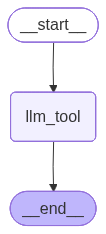

In [91]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
builder=StateGraph(State)

builder.add_node("llm_tool",llm_tool)

builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [92]:

## invocation

messages=graph.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (1hs37p402)
 Call ID: 1hs37p402
  Args:
    a: 2
    b: 2


In [93]:
tools=[add]


In [94]:
tools

[<function __main__.add(a: int, b: int) -> int>]

---

## 8. Conditional Edges  

Sometimes, the next step depends on the result.  

- If the LLM produces a **tool call** → go to the **Tool Node**  
- If the LLM does **not** call a tool → go directly to **END**  

This is handled by **conditional edges**, which let the graph decide dynamically which path to take.  


In [96]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder=StateGraph(State)

## Add nodes

builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))

## Add Edge
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges(
    "llm_tool",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)
graph_builder = builder.compile()


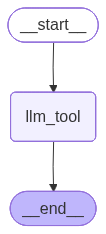

In [97]:
display(Image(graph.get_graph().draw_mermaid_png()))


In [101]:

## invocation

messages=graph.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()



messages=graph.invoke({"messages":"what is Machine Learning"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (2j7z23h4v)
 Call ID: 2j7z23h4v
  Args:
    a: 2
    b: 2
================================ Human Message =================================

what is Machine Learning
================================== Ai Message ==================================

Machine Learning is a subset of Artificial Intelligence (AI) that enables machines to learn from data and improve their performance on a task without being explicitly programmed. It involves the use of algorithms that allow machines to automatically improve their accuracy on a task by learning from experience and adapting to new data.

Machine Learning is a key technology in the field of AI, and it has many applications in areas such as:

* Image and speech recognition
* Natural Language Processing (NLP)
* Predictive maintenance
* Recommendation sys

---

## ✅ Summary  

- **Messages** → maintain the conversation state  
- **Chat models** → generate intelligent responses  
- **Tools** → extend the model’s abilities  
- **Reducers** → ensure history is preserved  
- **Graph nodes + edges** → define the flow of execution  